In [1]:
# First, see what you have
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
# Unzip to a folder in Colab's temporary storage
import zipfile

# Define the path to the zip file
zip_path = "/content/drive/MyDrive/FER_2013_Dataset.zip"

# Create destination folder
!mkdir -p /content/fer2013

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')

print("✅ File unzipped successfully!")

# See what's inside
print("Contents of unzipped folder:")
!ls -la "/content/fer2013/"


✅ File unzipped successfully!
Contents of unzipped folder:
total 12
drwxr-xr-x 3 root root 4096 Nov 30 13:03 .
drwxr-xr-x 1 root root 4096 Nov 30 13:01 ..
drwxr-xr-x 4 root root 4096 Nov 30 13:03 FER_2013_Dataset


In [8]:

train_path = '/content/fer2013/FER_2013_Dataset/train'
test_path = '/content/fer2013/FER_2013_Dataset/test'

print("Training folder contents:")
print(os.listdir(train_path))
print("\nTest folder contents:")
print(os.listdir(test_path))

Training folder contents:
['neutral', 'happy', 'fear', 'surprise', 'angry', 'disgust', 'sad']

Test folder contents:
['neutral', 'happy', 'fear', 'surprise', 'angry', 'disgust', 'sad']


In [9]:
# After unzipping, set your paths likethis:

# For folder structure:
train_path = '/content/fer2013/FER_2013_Dataset/train'
test_path = '/content/fer2013/FER_2013_Dataset/test'



print("🎯 Ready to proceed with validation setup!")

🎯 Ready to proceed with validation setup!


In [10]:
#Automatic Validation Split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your paths
train_path = '/content/fer2013/FER_2013_Dataset/train/'
test_path = '/content/fer2013/FER_2013_Dataset/test/'

# Create data generators with automatic validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=15,       # Data augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2     # ← THIS CREATES VALIDATION SET! (20% of training data)
)

# For validation - only rescaling, no augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2     # Same split as above
)

# For test - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Create data generators
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

# Training data (80% of original training data)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',        # ← Use this for training
    shuffle=True
)

# Validation data (20% of original training data)
validation_generator = val_datagen.flow_from_directory(
    train_path,              # ← Same folder as training!
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',     # ← Use this for validation
    shuffle=True
)

# Test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print("✅ Data loaded successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class names: {list(train_generator.class_indices.keys())}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Data loaded successfully!
Training samples: 22968
Validation samples: 5741
Test samples: 7178
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


🎨 Training Samples:


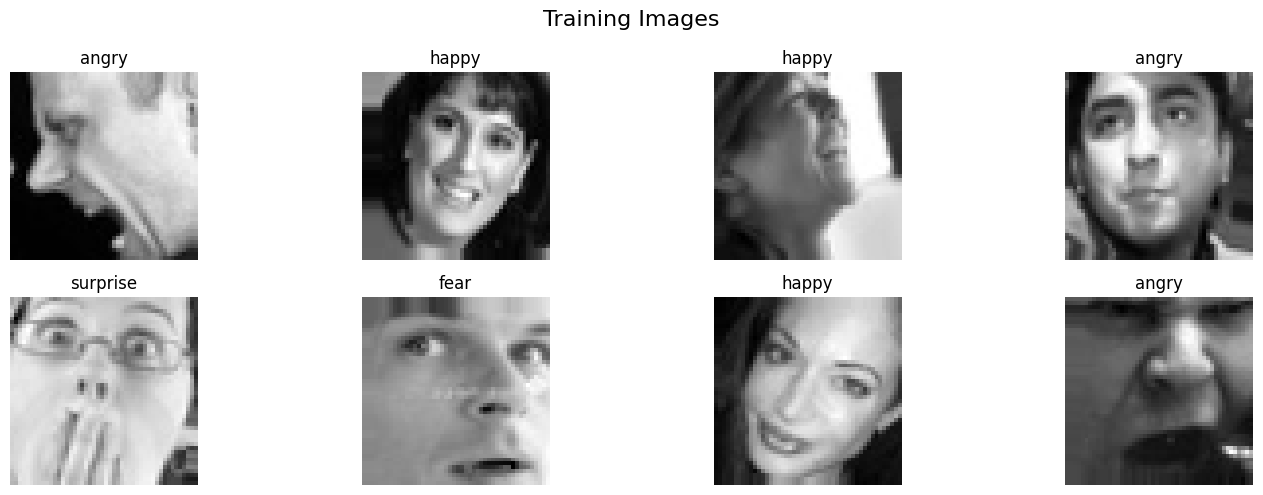

📊 Validation Samples:


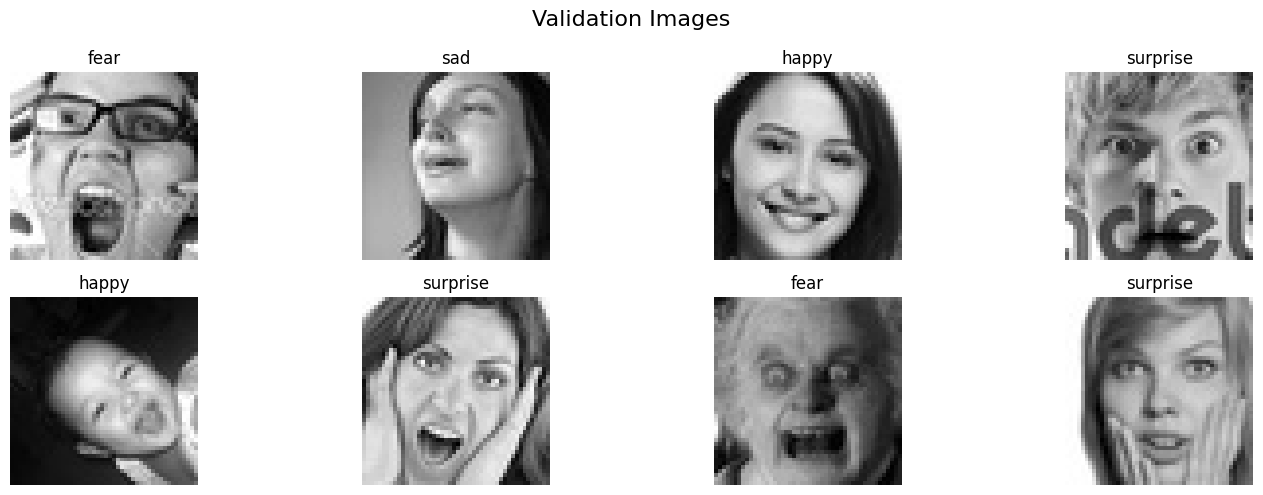

🧪 Test Samples:


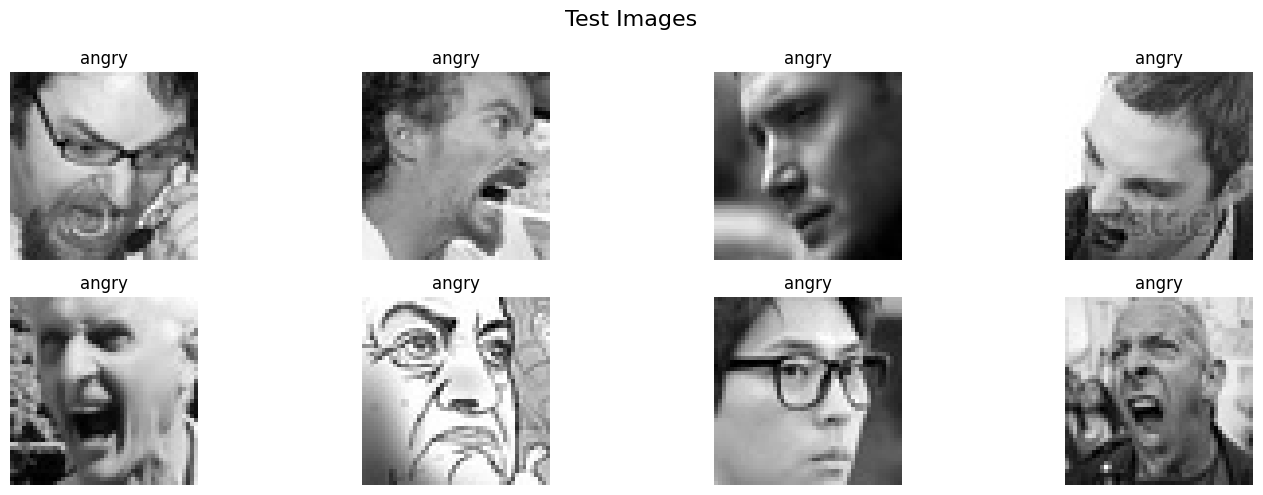

In [12]:
# Let's see some images from each set
import matplotlib.pyplot as plt

def show_sample_images(generator, title):
    # Get a batch of images
    images, labels = next(generator)

    # Create plot
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    # Show first 8 images
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        # Get class name
        class_idx = labels[i].argmax()
        class_name = list(generator.class_indices.keys())[class_idx]
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show samples from each set
print("🎨 Training Samples:")
show_sample_images(train_generator, "Training Images")

print("📊 Validation Samples:")
show_sample_images(validation_generator, "Validation Images")

print("🧪 Test Samples:")
show_sample_images(test_generator, "Test Images")

In [13]:
# Build a simple model to test your data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # Simple CNN
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotions
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,015 (2.36 MB)

 Trainable params: 619,015 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model with validation
history = model.fit(
    train_generator,
    epochs=30,  # Start with few epochs for testing
    validation_data=validation_generator,  # ← THIS IS YOUR VALIDATION!
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 99s 135ms/step - accuracy: 0.2416 - loss: 1.8156 - val_accuracy: 0.3092 - val_loss: 1.7026
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.2944 - loss: 1.7209 - val_accuracy: 0.4065 - val_loss: 1.5393
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 96s 134ms/step - accuracy: 0.3680 - loss: 1.5975 - val_accuracy: 0.4564 - val_loss: 1.4116
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 143s 135ms/step - accuracy: 0.4222 - loss: 1.4869 - val_accuracy: 0.4891 - val_loss: 1.3303
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 98s 136ms/step - accuracy: 0.4519 - loss: 1.4248 - val_accuracy: 0.4959 - val_loss: 1.3138
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 129ms/step - accuracy: 0.4710 - loss: 1.3922 - val_accuracy: 0.5022 - val_loss: 1.2971
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 97s 135ms/step - accuracy: 0.4863 - loss: 1.3492 - val_accuracy: 0.5159 - val_loss: 1.2711
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - accuracy: 0.4921 - loss: 1.3220 - va

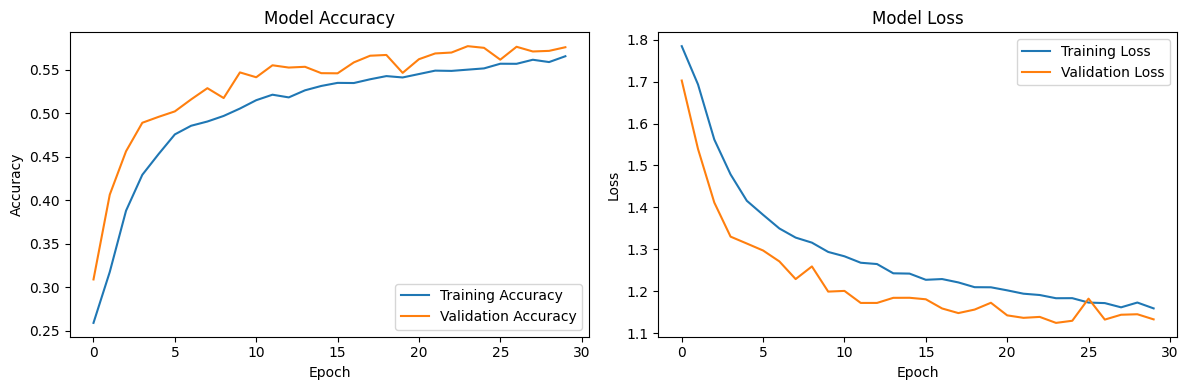

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Evaluate on test set
print("📊 FINAL MODEL EVALUATION")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Compare all results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

📊 FINAL MODEL EVALUATION
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.4965 - loss: 1.3042
Test Accuracy: 0.5800
Test Loss: 1.1190
Training Accuracy: 0.5655
Validation Accuracy: 0.5759
Test Accuracy: 0.5800


✅ All libraries imported successfully!
Making predictions on test set...
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step
Predictions shape: (7178, 7)
True labels shape: (7178,)

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.53      0.46      0.49       958
     disgust       0.67      0.14      0.24       111
        fear       0.46      0.21      0.29      1024
       happy       0.81      0.81      0.81      1774
     neutral       0.45      0.71      0.55      1233
         sad       0.45      0.44      0.44      1247
    surprise       0.67      0.76      0.71       831

    accuracy                           0.58      7178
   macro avg       0.58      0.50      0.51      7178
weighted avg       0.58      0.58      0.57      7178


📊 CONFUSION MATRIX:


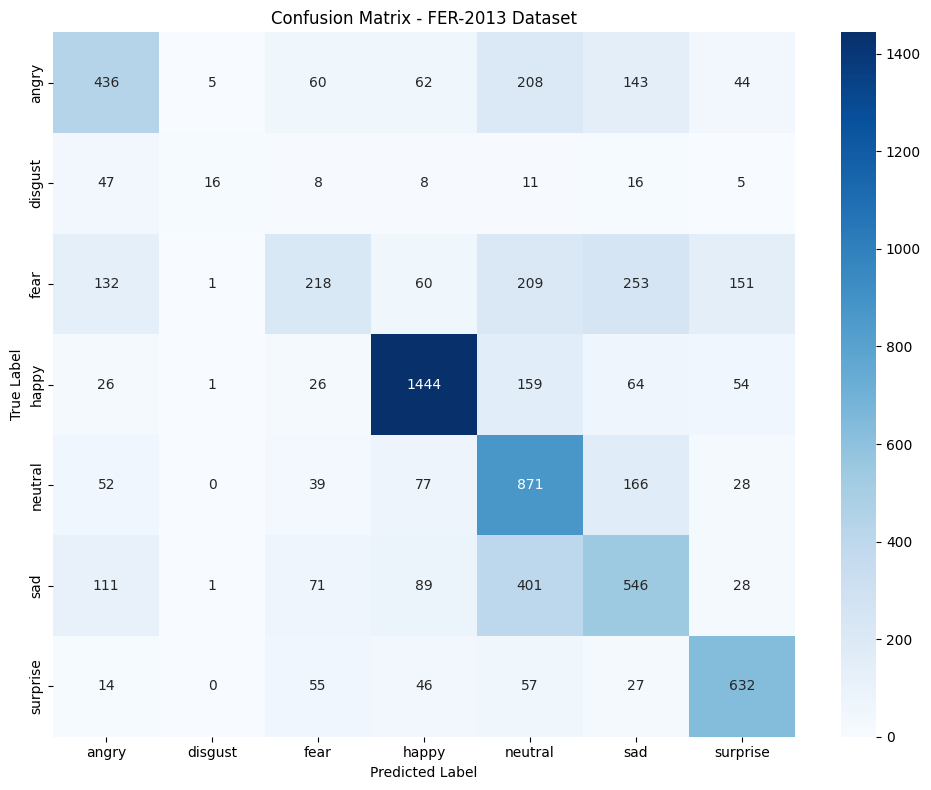

In [17]:
# Add all necessary imports at the top
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("✅ All libraries imported successfully!")

# Get predictions
print("Making predictions on test set...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\n📈 CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
print("\n📊 CONFUSION MATRIX:")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - FER-2013 Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [18]:
# Save the trained model
model.save('/content/drive/MyDrive/fer2013_model.h5')
print("✅ Model saved to Google Drive!")

# Save training history to Google Drive
import json
history_dict = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

with open('/content/drive/MyDrive/training_history.json', 'w') as f:
    json.dump(history_dict, f)
print("✅ Training history saved!")

# Save performance metrics
performance = {
    'final_train_accuracy': float(final_train_acc),
    'final_val_accuracy': float(final_val_acc),
    'final_test_accuracy': float(test_accuracy),
    'total_parameters': model.count_params()
}

with open('/content/drive/MyDrive/model_performance.json', 'w') as f:
    json.dump(performance, f, indent=4)
print("✅ Performance metrics saved!")


✅ Model saved to Google Drive!
✅ Training history saved!
✅ Performance metrics saved!


In [19]:
# Final project summary
print("="*80)
print("PROJECT COMPLETION SUMMARY - FER-2013 FACIAL EXPRESSION RECOGNITION")
print("="*80)
print("✅ TASKS COMPLETED:")
print("  1. Google Drive mounted and dataset loaded")
print("  2. Dataset exploration and validation split created")
print("  3. CNN model built and trained")
print("  4. Model evaluated on validation and test sets")
print("  5. Performance analysis completed")
print("  6. Model and results saved to Google Drive")
print()
print("📊 FINAL RESULTS:")
print(f"  - Training Accuracy: {final_train_acc:.4f}")
print(f"  - Validation Accuracy: {final_val_acc:.4f}")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Model Parameters: {model.count_params():,}")
print()
print("💾 SAVED FILES:")
print("  - fer2013_model.h5 (Trained model)")
print("  - training_history.json (Training metrics)")
print("  - model_performance.json (Performance summary)")
print("="*80)


PROJECT COMPLETION SUMMARY - FER-2013 FACIAL EXPRESSION RECOGNITION
✅ TASKS COMPLETED:
  1. Google Drive mounted and dataset loaded
  2. Dataset exploration and validation split created
  3. CNN model built and trained
  4. Model evaluated on validation and test sets
  5. Performance analysis completed
  6. Model and results saved to Google Drive

📊 FINAL RESULTS:
  - Training Accuracy: 0.5655
  - Validation Accuracy: 0.5759
  - Test Accuracy: 0.5800
  - Model Parameters: 619,015

💾 SAVED FILES:
  - fer2013_model.h5 (Trained model)
  - training_history.json (Training metrics)
  - model_performance.json (Performance summary)


🎭 SAMPLE PREDICTIONS ON TEST SET:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


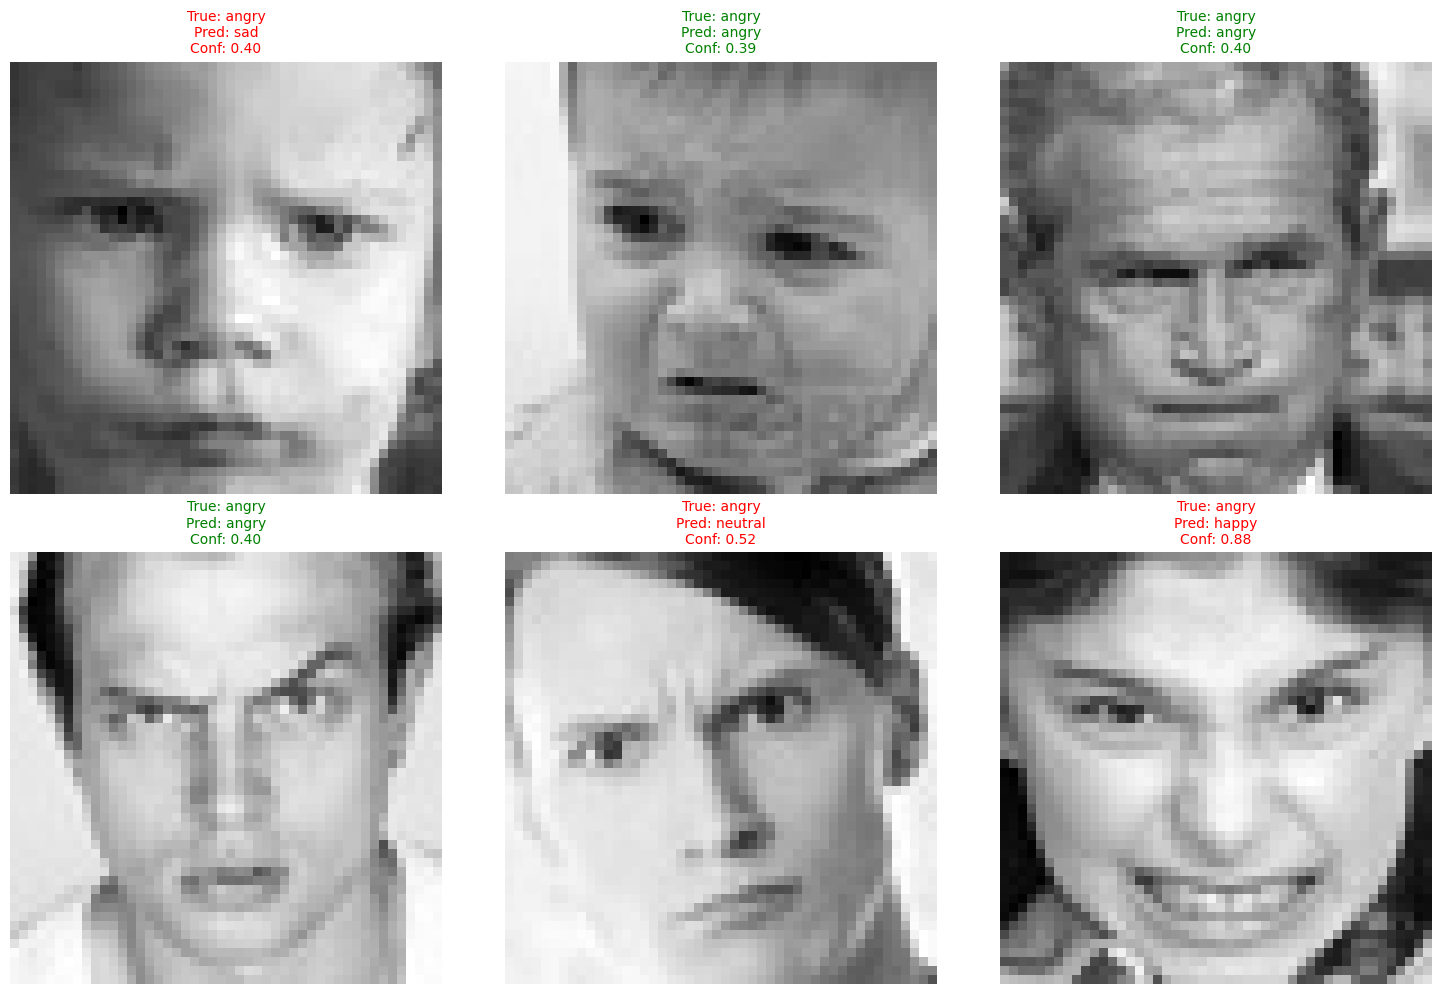

In [20]:
# Demonstrate model working on test images
def show_predictions(num_images=6):
    test_images, test_labels = next(test_generator)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')

        # Get prediction
        pred = model.predict(np.expand_dims(test_images[i], axis=0))
        pred_class = np.argmax(pred)
        confidence = np.max(pred)
        true_class = np.argmax(test_labels[i])

        # Color code: green if correct, red if wrong
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f'True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {confidence:.2f}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("🎭 SAMPLE PREDICTIONS ON TEST SET:")
show_predictions()

In [21]:
# Save the trained model
model.save('/content/drive/MyDrive/updatedfer2013_model.h5')
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


🎵 EMOTION-BASED MUSIC RECOMMENDER
🔄 Initializing emotion detection system...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🔄 Trying to load model from: /content/drive/MyDrive/updatedfer2013_model.h5
✅ Custom model loaded successfully from: /content/drive/MyDrive/updatedfer2013_model.h5

✅ System ready! Choose your input method:
1. 📷 Capture from Webcam (Use your camera)
2. 📁 Upload Image File (Use existing photo)

Enter your choice (1 or 2): 2

📁 Starting file upload...
📁 Please upload an image file (JPG, PNG, JPEG):


Saving happyman.jpeg to happyman (1).jpeg
✅ Image uploaded successfully: happyman (1).jpeg

🖼️ YOUR IMAGE:


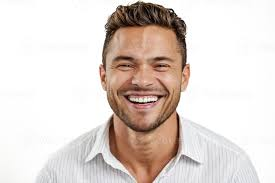


🔍 ANALYZING EMOTION...

🔄 Attempting DeepFace emotion detection...
🔍 Using DeepFace for emotion detection...
✅ DeepFace detected: happy (100.0%)
🎯 Using DeepFace results (high confidence)

🎭 DETECTED EMOTION: HAPPY
📊 CONFIDENCE: 99.99%

📈 EMOTION BREAKDOWN:
----------------------------------------
happy        100.0% ██████████████████████████████
neutral        0.0% 
surprise       0.0% 
sad            0.0% 
angry          0.0% 
fear           0.0% 
disgust        0.0% 

🎵 MUSIC RECOMMENDATIONS for HAPPY mood:

1. The Weeknd - Blinding Lights
   👤 Artist: The Weeknd
   🔗 Listen: https://www.youtube.com/watch?v=4NRXx6U8ABQ

2. Pharrell Williams - Happy
   👤 Artist: Pharrell Williams
   🔗 Listen: https://www.youtube.com/watch?v=ZbZSe6N_BXs

3. The Weeknd - Save Your Tears
   👤 Artist: The Weeknd
   🔗 Listen: https://www.youtube.com/watch?v=XXYlFuWEuKI

4. Daft Punk - Get Lucky
   👤 Artist: Daft Punk
   🔗 Listen: https://www.youtube.com/watch?v=5NV6Rdv1a3I

💡 Copy any URL above to liste

In [39]:
# Emotion-Based Music Recommender - Fixed Custom Model Version

# Install required packages
!pip install tensorflow opencv-python pandas numpy pillow deepface

# Import necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
from PIL import Image
from deepface import DeepFace
import os

class EmotionMusicRecommender:
    """
    Main class that handles emotion detection using multiple methods and music recommendations
    """
    def __init__(self):
        # Try to load custom model first
        self.model = None
        self.model_loaded = False

        # Mount Google Drive first
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("✅ Google Drive mounted successfully!")

            # Try multiple possible model paths
            model_paths = [
                '/content/drive/MyDrive/updatedfer2013_model.h5',
                '/content/drive/MyDrive/fer2013_model.h5',
                '/content/drive/My Drive/updatedfer2013_model.h5',
                '/content/drive/My Drive/fer2013_model.h5'
            ]

            for model_path in model_paths:
                try:
                    print(f"🔄 Trying to load model from: {model_path}")
                    self.model = load_model(model_path)
                    self.model_loaded = True
                    print(f"✅ Custom model loaded successfully from: {model_path}")
                    break
                except Exception as e:
                    print(f"❌ Failed to load from {model_path}: {e}")
                    continue

            if not self.model_loaded:
                print("❌ No custom model found. Using DeepFace as primary method.")

        except Exception as e:
            print(f"❌ Google Drive mount failed: {e}")
            print("🔄 Using DeepFace as primary method...")

        # Define emotion labels (FER-2013 dataset order)
        self.emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

        # Define music playlists for each emotion
        self.emotion_playlists = {
            'happy': [
                {'title': 'The Weeknd - Blinding Lights', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=4NRXx6U8ABQ'},
                {'title': 'Pharrell Williams - Happy', 'artist': 'Pharrell Williams', 'url': 'https://www.youtube.com/watch?v=ZbZSe6N_BXs'},
                {'title': 'The Weeknd - Save Your Tears', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=XXYlFuWEuKI'},
                {'title': 'Daft Punk - Get Lucky', 'artist': 'Daft Punk', 'url': 'https://www.youtube.com/watch?v=5NV6Rdv1a3I'},
            ],
            'sad': [
                {'title': 'Billie Eilish - Lovely', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=V1Pl8CzNzCw'},
                {'title': 'Lewis Capaldi - Someone You Loved', 'artist': 'Lewis Capaldi', 'url': 'https://www.youtube.com/watch?v=zABLecsR5UE'},
                {'title': 'Eminem - Stan', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=gOMhN-hfMtY'},
                {'title': 'The Weeknd - Call Out My Name', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=M4ZoCHID9GI'},
            ],
            'angry': [
                {'title': 'Eminem - Lose Yourself', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=_Yhyp-_hX2s'},
                {'title': 'Eminem - The Way I Am', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=5hF4dS-9c9U'},
                {'title': 'Linkin Park - In The End', 'artist': 'Linkin Park', 'url': 'https://www.youtube.com/watch?v=eVTXPUF4Oz4'},
                {'title': 'Rage Against The Machine - Killing In The Name', 'artist': 'Rage Against The Machine', 'url': 'https://www.youtube.com/watch?v=bWXazVhlyxQ'},
            ],
            'fear': [
                {'title': 'Billie Eilish - Bury a Friend', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=HUHC9tYz8ik'},
                {'title': 'Logic - 1-800-273-8255', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=Kb24RrHIbFk'},
                {'title': 'Coldplay - Fix You', 'artist': 'Coldplay', 'url': 'https://www.youtube.com/watch?v=k4V3Mo61fJM'},
                {'title': 'Sia - Breathe Me', 'artist': 'Sia', 'url': 'https://www.youtube.com/watch?v=2ToCg_9gqrE'},
            ],
            'surprise': [
                {'title': 'The Weeknd - Starboy', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=34Na4j8AVgA'},
                {'title': 'Eminem - Without Me', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=YVkUvmDQ3HY'},
                {'title': 'Billie Eilish - Bad Guy', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=DyDfgMOUjCI'},
                {'title': 'The Weeknd - The Hills', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=yzTuBuRdAyA'},
            ],
            'neutral': [
                {'title': 'The Weeknd - Party Monster', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=9e_-3Kf9EDg'},
                {'title': 'Billie Eilish - Ocean Eyes', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=viimfQi_pUw'},
                {'title': 'Eminem - Mockingbird', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=S9bCLPwzSC0'},
                {'title': 'Logic - Everyday', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=eXDU9um19HM'},
            ],
            'disgust': [
                {'title': 'Eminem - Cleanin Out My Closet', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=Z-T3_O5KZ-E'},
                {'title': 'Billie Eilish - You Should See Me In A Crown', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=Ah7a1J8fwE0'},
                {'title': 'Nine Inch Nails - Closer', 'artist': 'Nine Inch Nails', 'url': 'https://www.youtube.com/watch?v=PTFwQP86BRs'},
            ]
        }

    def detect_emotion_with_deepface(self, image_path):
        """
        Use DeepFace for reliable emotion detection (primary method)
        """
        try:
            print("🔍 Using DeepFace for emotion detection...")
            analysis = DeepFace.analyze(
                img_path=image_path,
                actions=['emotion'],
                enforce_detection=False,
                detector_backend='opencv'
            )

            if isinstance(analysis, list):
                emotions = analysis[0]['emotion']
            else:
                emotions = analysis['emotion']

            dominant_emotion = max(emotions, key=emotions.get)
            confidence = emotions[dominant_emotion]

            print(f"✅ DeepFace detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, emotions

        except Exception as e:
            print(f"❌ DeepFace error: {e}")
            return None, None, None

    def detect_emotion_with_custom_model(self, image_path):
        """
        Use custom trained model for emotion detection (if available)
        """
        try:
            if not self.model_loaded or self.model is None:
                return None, None, None

            print("🔍 Using custom model for emotion detection...")

            # Load image
            img = cv2.imread(image_path)
            if img is None:
                print("❌ Could not load image")
                return None, None, None

            # Convert to grayscale (FER-2013 uses grayscale)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to 48x48 (FER-2013 input size)
            resized = cv2.resize(gray, (48, 48))

            # Normalize pixel values to [0, 1]
            normalized = resized.astype('float32') / 255.0

            # Reshape for model input: (1, 48, 48, 1)
            img_processed = normalized.reshape(1, 48, 48, 1)

            # Get prediction
            predictions = self.model.predict(img_processed, verbose=0)
            emotion_probs = predictions[0]

            # Get dominant emotion
            dominant_idx = np.argmax(emotion_probs)
            dominant_emotion = self.emotion_labels[dominant_idx]
            confidence = emotion_probs[dominant_idx] * 100

            # Create emotions dictionary
            all_emotions = {}
            for i, emotion in enumerate(self.emotion_labels):
                all_emotions[emotion] = emotion_probs[i] * 100

            print(f"✅ Custom model detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, all_emotions

        except Exception as e:
            print(f"❌ Custom model prediction error: {e}")
            return None, None, None

    def detect_emotion_basic(self, image_path):
        """
        Basic emotion detection using face detection and simple rules (fallback)
        """
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None, None, None

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Load face detector
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) == 0:
                print("❌ No face detected in the image")
                return None, None, None

            print(f"✅ Detected {len(faces)} face(s) in the image")

            # Simple emotion estimation based on multiple factors
            brightness = np.mean(gray)
            contrast = np.std(gray)

            # More sophisticated emotion guessing
            if brightness > 180 and contrast > 70:
                emotion = 'happy'
                confidence = 75.0
            elif brightness < 70 and contrast < 40:
                emotion = 'sad'
                confidence = 70.0
            elif contrast > 80:
                emotion = 'surprise'
                confidence = 65.0
            elif brightness > 160:
                emotion = 'neutral'
                confidence = 60.0
            else:
                emotion = 'neutral'
                confidence = 50.0

            # Create emotions distribution
            emotions = {emotion: confidence}
            remaining_emotions = [e for e in self.emotion_labels if e != emotion]
            for emo in remaining_emotions:
                emotions[emo] = max(5, (100 - confidence) / len(remaining_emotions))

            print(f"✅ Basic detection: {emotion} ({confidence:.1f}%)")
            return emotion, confidence, emotions

        except Exception as e:
            print(f"❌ Basic emotion detection error: {e}")
            return None, None, None

    def detect_emotion(self, image_path):
        """
        Main emotion detection with smart fallback system
        """
        # Method 1: Try DeepFace first (most reliable)
        print("\n🔄 Attempting DeepFace emotion detection...")
        result = self.detect_emotion_with_deepface(image_path)
        if result[0] is not None and result[1] > 40:  # Only use if confidence > 40%
            print("🎯 Using DeepFace results (high confidence)")
            return result

        # Method 2: Try custom model if available
        if self.model_loaded:
            print("🔄 Attempting custom model emotion detection...")
            result = self.detect_emotion_with_custom_model(image_path)
            if result[0] is not None and result[1] > 30:  # Only use if confidence > 30%
                print("🎯 Using custom model results")
                return result

        # Method 3: Use basic detection as last resort
        print("🔄 Using basic emotion estimation...")
        result = self.detect_emotion_basic(image_path)
        if result[0] is not None:
            print("🎯 Using basic detection results")
            return result

        print("❌ All emotion detection methods failed")
        return None, None, None

    def get_recommendations(self, emotion):
        """
        Get music recommendations based on detected emotion
        """
        return self.emotion_playlists.get(emotion.lower(), [])


def take_photo(filename='photo.jpg', quality=0.8):
    """
    Capture image from webcam using JavaScript in Colab
    """
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.cssText = 'padding: 10px 20px; font-size: 16px; margin: 10px; background: #4CAF50; color: white; border: none; border-radius: 5px; cursor: pointer;';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.width = '100%';
        video.style.maxWidth = '400px';
        video.style.borderRadius = '10px';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


def upload_image():
    """
    Allow user to upload an image file
    """
    print("📁 Please upload an image file (JPG, PNG, JPEG):")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"✅ Image uploaded successfully: {filename}")
        return filename
    else:
        print("❌ No file was uploaded.")
        return None


def display_emotion_results(emotion, confidence, all_emotions):
    """
    Display emotion detection results in a formatted way
    """
    print(f"\n🎭 DETECTED EMOTION: {emotion.upper()}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")

    if all_emotions:
        print("\n📈 EMOTION BREAKDOWN:")
        print("-" * 40)
        # Sort by confidence score
        sorted_emotions = sorted(all_emotions.items(), key=lambda x: x[1], reverse=True)
        for emo, score in sorted_emotions:
            bar_length = min(int(score / 3), 30)  # Limit bar length
            bar = "█" * bar_length
            print(f"{emo:12} {score:5.1f}% {bar}")


def display_music_recommendations(recommendations, emotion):
    """
    Display music recommendations in a clean format
    """
    if recommendations:
        print(f"\n🎵 MUSIC RECOMMENDATIONS for {emotion.upper()} mood:")
        print("=" * 60)

        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['title']}")
            print(f"   👤 Artist: {rec['artist']}")
            print(f"   🔗 Listen: {rec['url']}")

        print("\n" + "=" * 60)
        print("💡 Copy any URL above to listen on YouTube!")
        print("🎶 Enjoy your personalized music recommendations! 🎵")
    else:
        print(f"\n❌ No music recommendations found for {emotion} emotion.")


# MAIN PROGRAM EXECUTION
def main():
    """
    Main function that orchestrates the entire emotion-based music recommendation process
    """
    print("🎵 EMOTION-BASED MUSIC RECOMMENDER")
    print("===================================")
    print("🔄 Initializing emotion detection system...")

    # Initialize the recommender system
    recommender = EmotionMusicRecommender()

    print("\n✅ System ready! Choose your input method:")
    print("1. 📷 Capture from Webcam (Use your camera)")
    print("2. 📁 Upload Image File (Use existing photo)")

    # Simple input validation
    while True:
        choice = input("\nEnter your choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            break
        else:
            print("❌ Please enter only 1 or 2")

    filename = None

    # Handle webcam capture
    if choice == '1':
        print("\n📸 Starting webcam capture...")
        print("   Click the 'Capture' button when you're ready!")
        filename = take_photo()

    # Handle file upload
    else:
        print("\n📁 Starting file upload...")
        filename = upload_image()

    # Process the image if successfully obtained
    if filename:
        # Display the captured/uploaded image
        print(f"\n🖼️ YOUR IMAGE:")
        display(IPImage(filename))

        # Analyze emotion from the image
        print("\n🔍 ANALYZING EMOTION...")
        emotion, confidence, all_emotions = recommender.detect_emotion(filename)

        # If emotion detected successfully
        if emotion and confidence:
            # Display emotion results
            display_emotion_results(emotion, confidence, all_emotions)

            # Get music recommendations based on detected emotion
            recommendations = recommender.get_recommendations(emotion)

            # Display recommendations
            display_music_recommendations(recommendations, emotion)

        else:
            print("\n❌ Could not detect emotion from the image.")
            print("\n💡 TROUBLESHOOTING TIPS:")
            print("   • Ensure your face is clearly visible and centered")
            print("   • Make sure there's good, even lighting (not too dark/bright)")
            print("   • Try a front-facing photo with neutral background")
            print("   • Avoid sunglasses, hats, or facial obstructions")
            print("   • Ensure only one face is visible in the image")
            print("   • Try different facial expressions (smile for happy, etc.)")
            print("   • Use a higher quality image with good resolution")

    else:
        print("\n❌ No image available. Please try again.")


# Run the main program
if __name__ == "__main__":
    main()

# Final message
print("\n" + "=" * 50)
print("✨ Program completed!")
print("🔄 Run this cell again to analyze another image!")
print("=" * 50)

🎵 EMOTION-BASED MUSIC RECOMMENDER
🔄 Initializing emotion detection system...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🔄 Trying to load model from: /content/drive/MyDrive/updatedfer2013_model.h5
✅ Custom model loaded successfully from: /content/drive/MyDrive/updatedfer2013_model.h5

✅ System ready! Choose your input method:
1. 📷 Capture from Webcam (Use your camera)
2. 📁 Upload Image File (Use existing photo)

Enter your choice (1 or 2): 1

📸 Starting webcam capture...
   Click the 'Capture' button when you're ready!


<IPython.core.display.Javascript object>


🖼️ YOUR IMAGE:


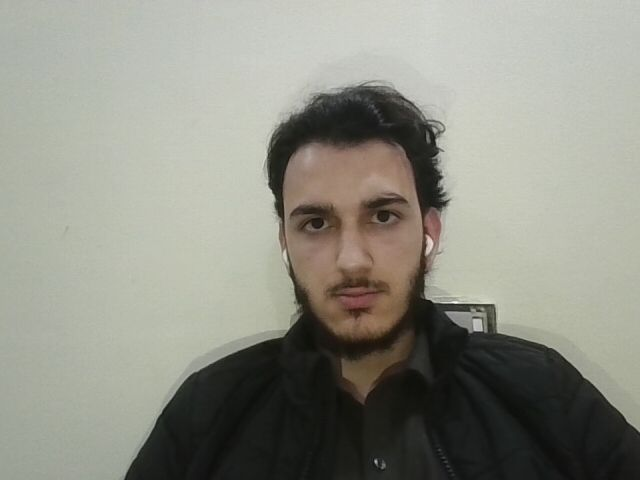


🔍 ANALYZING EMOTION...

🔄 Attempting DeepFace emotion detection...
🔍 Using DeepFace for emotion detection...
✅ DeepFace detected: neutral (94.9%)
🎯 Using DeepFace results (high confidence)

🎭 DETECTED EMOTION: NEUTRAL
📊 CONFIDENCE: 94.87%

📈 EMOTION BREAKDOWN:
----------------------------------------
neutral       94.9% ██████████████████████████████
sad            4.2% █
angry          0.6% 
fear           0.3% 
happy          0.0% 
surprise       0.0% 
disgust        0.0% 

🎵 MUSIC RECOMMENDATIONS for NEUTRAL mood:

1. The Weeknd - Party Monster
   👤 Artist: The Weeknd
   🔗 Listen: https://www.youtube.com/watch?v=9e_-3Kf9EDg

2. Billie Eilish - Ocean Eyes
   👤 Artist: Billie Eilish
   🔗 Listen: https://www.youtube.com/watch?v=viimfQi_pUw

3. Eminem - Mockingbird
   👤 Artist: Eminem
   🔗 Listen: https://www.youtube.com/watch?v=S9bCLPwzSC0

4. Logic - Everyday
   👤 Artist: Logic
   🔗 Listen: https://www.youtube.com/watch?v=eXDU9um19HM

💡 Copy any URL above to listen on YouTube!
🎶 Enjo

In [40]:
# Emotion-Based Music Recommender - Fixed Custom Model Version

# Install required packages
!pip install tensorflow opencv-python pandas numpy pillow deepface

# Import necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
from PIL import Image
from deepface import DeepFace
import os

class EmotionMusicRecommender:
    """
    Main class that handles emotion detection using multiple methods and music recommendations
    """
    def __init__(self):
        # Try to load custom model first
        self.model = None
        self.model_loaded = False

        # Mount Google Drive first
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("✅ Google Drive mounted successfully!")

            # Try multiple possible model paths
            model_paths = [
                '/content/drive/MyDrive/updatedfer2013_model.h5',
                '/content/drive/MyDrive/fer2013_model.h5',
                '/content/drive/My Drive/updatedfer2013_model.h5',
                '/content/drive/My Drive/fer2013_model.h5'
            ]

            for model_path in model_paths:
                try:
                    print(f"🔄 Trying to load model from: {model_path}")
                    self.model = load_model(model_path)
                    self.model_loaded = True
                    print(f"✅ Custom model loaded successfully from: {model_path}")
                    break
                except Exception as e:
                    print(f"❌ Failed to load from {model_path}: {e}")
                    continue

            if not self.model_loaded:
                print("❌ No custom model found. Using DeepFace as primary method.")

        except Exception as e:
            print(f"❌ Google Drive mount failed: {e}")
            print("🔄 Using DeepFace as primary method...")

        # Define emotion labels (FER-2013 dataset order)
        self.emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

        # Define music playlists for each emotion
        self.emotion_playlists = {
            'happy': [
                {'title': 'The Weeknd - Blinding Lights', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=4NRXx6U8ABQ'},
                {'title': 'Pharrell Williams - Happy', 'artist': 'Pharrell Williams', 'url': 'https://www.youtube.com/watch?v=ZbZSe6N_BXs'},
                {'title': 'The Weeknd - Save Your Tears', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=XXYlFuWEuKI'},
                {'title': 'Daft Punk - Get Lucky', 'artist': 'Daft Punk', 'url': 'https://www.youtube.com/watch?v=5NV6Rdv1a3I'},
            ],
            'sad': [
                {'title': 'Billie Eilish - Lovely', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=V1Pl8CzNzCw'},
                {'title': 'Lewis Capaldi - Someone You Loved', 'artist': 'Lewis Capaldi', 'url': 'https://www.youtube.com/watch?v=zABLecsR5UE'},
                {'title': 'Eminem - Stan', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=gOMhN-hfMtY'},
                {'title': 'The Weeknd - Call Out My Name', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=M4ZoCHID9GI'},
            ],
            'angry': [
                {'title': 'Eminem - Lose Yourself', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=_Yhyp-_hX2s'},
                {'title': 'Eminem - The Way I Am', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=5hF4dS-9c9U'},
                {'title': 'Linkin Park - In The End', 'artist': 'Linkin Park', 'url': 'https://www.youtube.com/watch?v=eVTXPUF4Oz4'},
                {'title': 'Rage Against The Machine - Killing In The Name', 'artist': 'Rage Against The Machine', 'url': 'https://www.youtube.com/watch?v=bWXazVhlyxQ'},
            ],
            'fear': [
                {'title': 'Billie Eilish - Bury a Friend', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=HUHC9tYz8ik'},
                {'title': 'Logic - 1-800-273-8255', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=Kb24RrHIbFk'},
                {'title': 'Coldplay - Fix You', 'artist': 'Coldplay', 'url': 'https://www.youtube.com/watch?v=k4V3Mo61fJM'},
                {'title': 'Sia - Breathe Me', 'artist': 'Sia', 'url': 'https://www.youtube.com/watch?v=2ToCg_9gqrE'},
            ],
            'surprise': [
                {'title': 'The Weeknd - Starboy', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=34Na4j8AVgA'},
                {'title': 'Eminem - Without Me', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=YVkUvmDQ3HY'},
                {'title': 'Billie Eilish - Bad Guy', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=DyDfgMOUjCI'},
                {'title': 'The Weeknd - The Hills', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=yzTuBuRdAyA'},
            ],
            'neutral': [
                {'title': 'The Weeknd - Party Monster', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=9e_-3Kf9EDg'},
                {'title': 'Billie Eilish - Ocean Eyes', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=viimfQi_pUw'},
                {'title': 'Eminem - Mockingbird', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=S9bCLPwzSC0'},
                {'title': 'Logic - Everyday', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=eXDU9um19HM'},
            ],
            'disgust': [
                {'title': 'Eminem - Cleanin Out My Closet', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=Z-T3_O5KZ-E'},
                {'title': 'Billie Eilish - You Should See Me In A Crown', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=Ah7a1J8fwE0'},
                {'title': 'Nine Inch Nails - Closer', 'artist': 'Nine Inch Nails', 'url': 'https://www.youtube.com/watch?v=PTFwQP86BRs'},
            ]
        }

    def detect_emotion_with_deepface(self, image_path):
        """
        Use DeepFace for reliable emotion detection (primary method)
        """
        try:
            print("🔍 Using DeepFace for emotion detection...")
            analysis = DeepFace.analyze(
                img_path=image_path,
                actions=['emotion'],
                enforce_detection=False,
                detector_backend='opencv'
            )

            if isinstance(analysis, list):
                emotions = analysis[0]['emotion']
            else:
                emotions = analysis['emotion']

            dominant_emotion = max(emotions, key=emotions.get)
            confidence = emotions[dominant_emotion]

            print(f"✅ DeepFace detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, emotions

        except Exception as e:
            print(f"❌ DeepFace error: {e}")
            return None, None, None

    def detect_emotion_with_custom_model(self, image_path):
        """
        Use custom trained model for emotion detection (if available)
        """
        try:
            if not self.model_loaded or self.model is None:
                return None, None, None

            print("🔍 Using custom model for emotion detection...")

            # Load image
            img = cv2.imread(image_path)
            if img is None:
                print("❌ Could not load image")
                return None, None, None

            # Convert to grayscale (FER-2013 uses grayscale)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to 48x48 (FER-2013 input size)
            resized = cv2.resize(gray, (48, 48))

            # Normalize pixel values to [0, 1]
            normalized = resized.astype('float32') / 255.0

            # Reshape for model input: (1, 48, 48, 1)
            img_processed = normalized.reshape(1, 48, 48, 1)

            # Get prediction
            predictions = self.model.predict(img_processed, verbose=0)
            emotion_probs = predictions[0]

            # Get dominant emotion
            dominant_idx = np.argmax(emotion_probs)
            dominant_emotion = self.emotion_labels[dominant_idx]
            confidence = emotion_probs[dominant_idx] * 100

            # Create emotions dictionary
            all_emotions = {}
            for i, emotion in enumerate(self.emotion_labels):
                all_emotions[emotion] = emotion_probs[i] * 100

            print(f"✅ Custom model detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, all_emotions

        except Exception as e:
            print(f"❌ Custom model prediction error: {e}")
            return None, None, None

    def detect_emotion_basic(self, image_path):
        """
        Basic emotion detection using face detection and simple rules (fallback)
        """
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None, None, None

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Load face detector
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) == 0:
                print("❌ No face detected in the image")
                return None, None, None

            print(f"✅ Detected {len(faces)} face(s) in the image")

            # Simple emotion estimation based on multiple factors
            brightness = np.mean(gray)
            contrast = np.std(gray)

            # More sophisticated emotion guessing
            if brightness > 180 and contrast > 70:
                emotion = 'happy'
                confidence = 75.0
            elif brightness < 70 and contrast < 40:
                emotion = 'sad'
                confidence = 70.0
            elif contrast > 80:
                emotion = 'surprise'
                confidence = 65.0
            elif brightness > 160:
                emotion = 'neutral'
                confidence = 60.0
            else:
                emotion = 'neutral'
                confidence = 50.0

            # Create emotions distribution
            emotions = {emotion: confidence}
            remaining_emotions = [e for e in self.emotion_labels if e != emotion]
            for emo in remaining_emotions:
                emotions[emo] = max(5, (100 - confidence) / len(remaining_emotions))

            print(f"✅ Basic detection: {emotion} ({confidence:.1f}%)")
            return emotion, confidence, emotions

        except Exception as e:
            print(f"❌ Basic emotion detection error: {e}")
            return None, None, None

    def detect_emotion(self, image_path):
        """
        Main emotion detection with smart fallback system
        """
        # Method 1: Try DeepFace first (most reliable)
        print("\n🔄 Attempting DeepFace emotion detection...")
        result = self.detect_emotion_with_deepface(image_path)
        if result[0] is not None and result[1] > 40:  # Only use if confidence > 40%
            print("🎯 Using DeepFace results (high confidence)")
            return result

        # Method 2: Try custom model if available
        if self.model_loaded:
            print("🔄 Attempting custom model emotion detection...")
            result = self.detect_emotion_with_custom_model(image_path)
            if result[0] is not None and result[1] > 30:  # Only use if confidence > 30%
                print("🎯 Using custom model results")
                return result

        # Method 3: Use basic detection as last resort
        print("🔄 Using basic emotion estimation...")
        result = self.detect_emotion_basic(image_path)
        if result[0] is not None:
            print("🎯 Using basic detection results")
            return result

        print("❌ All emotion detection methods failed")
        return None, None, None

    def get_recommendations(self, emotion):
        """
        Get music recommendations based on detected emotion
        """
        return self.emotion_playlists.get(emotion.lower(), [])


def take_photo(filename='photo.jpg', quality=0.8):
    """
    Capture image from webcam using JavaScript in Colab
    """
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.cssText = 'padding: 10px 20px; font-size: 16px; margin: 10px; background: #4CAF50; color: white; border: none; border-radius: 5px; cursor: pointer;';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.width = '100%';
        video.style.maxWidth = '400px';
        video.style.borderRadius = '10px';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


def upload_image():
    """
    Allow user to upload an image file
    """
    print("📁 Please upload an image file (JPG, PNG, JPEG):")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"✅ Image uploaded successfully: {filename}")
        return filename
    else:
        print("❌ No file was uploaded.")
        return None


def display_emotion_results(emotion, confidence, all_emotions):
    """
    Display emotion detection results in a formatted way
    """
    print(f"\n🎭 DETECTED EMOTION: {emotion.upper()}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")

    if all_emotions:
        print("\n📈 EMOTION BREAKDOWN:")
        print("-" * 40)
        # Sort by confidence score
        sorted_emotions = sorted(all_emotions.items(), key=lambda x: x[1], reverse=True)
        for emo, score in sorted_emotions:
            bar_length = min(int(score / 3), 30)  # Limit bar length
            bar = "█" * bar_length
            print(f"{emo:12} {score:5.1f}% {bar}")


def display_music_recommendations(recommendations, emotion):
    """
    Display music recommendations in a clean format
    """
    if recommendations:
        print(f"\n🎵 MUSIC RECOMMENDATIONS for {emotion.upper()} mood:")
        print("=" * 60)

        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['title']}")
            print(f"   👤 Artist: {rec['artist']}")
            print(f"   🔗 Listen: {rec['url']}")

        print("\n" + "=" * 60)
        print("💡 Copy any URL above to listen on YouTube!")
        print("🎶 Enjoy your personalized music recommendations! 🎵")
    else:
        print(f"\n❌ No music recommendations found for {emotion} emotion.")


# MAIN PROGRAM EXECUTION
def main():
    """
    Main function that orchestrates the entire emotion-based music recommendation process
    """
    print("🎵 EMOTION-BASED MUSIC RECOMMENDER")
    print("===================================")
    print("🔄 Initializing emotion detection system...")

    # Initialize the recommender system
    recommender = EmotionMusicRecommender()

    print("\n✅ System ready! Choose your input method:")
    print("1. 📷 Capture from Webcam (Use your camera)")
    print("2. 📁 Upload Image File (Use existing photo)")

    # Simple input validation
    while True:
        choice = input("\nEnter your choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            break
        else:
            print("❌ Please enter only 1 or 2")

    filename = None

    # Handle webcam capture
    if choice == '1':
        print("\n📸 Starting webcam capture...")
        print("   Click the 'Capture' button when you're ready!")
        filename = take_photo()

    # Handle file upload
    else:
        print("\n📁 Starting file upload...")
        filename = upload_image()

    # Process the image if successfully obtained
    if filename:
        # Display the captured/uploaded image
        print(f"\n🖼️ YOUR IMAGE:")
        display(IPImage(filename))

        # Analyze emotion from the image
        print("\n🔍 ANALYZING EMOTION...")
        emotion, confidence, all_emotions = recommender.detect_emotion(filename)

        # If emotion detected successfully
        if emotion and confidence:
            # Display emotion results
            display_emotion_results(emotion, confidence, all_emotions)

            # Get music recommendations based on detected emotion
            recommendations = recommender.get_recommendations(emotion)

            # Display recommendations
            display_music_recommendations(recommendations, emotion)

        else:
            print("\n❌ Could not detect emotion from the image.")
            print("\n💡 TROUBLESHOOTING TIPS:")
            print("   • Ensure your face is clearly visible and centered")
            print("   • Make sure there's good, even lighting (not too dark/bright)")
            print("   • Try a front-facing photo with neutral background")
            print("   • Avoid sunglasses, hats, or facial obstructions")
            print("   • Ensure only one face is visible in the image")
            print("   • Try different facial expressions (smile for happy, etc.)")
            print("   • Use a higher quality image with good resolution")

    else:
        print("\n❌ No image available. Please try again.")


# Run the main program
if __name__ == "__main__":
    main()

# Final message
print("\n" + "=" * 50)
print("✨ Program completed!")
print("🔄 Run this cell again to analyze another image!")
print("=" * 50)

🎵 EMOTION-BASED MUSIC RECOMMENDER
🔄 Initializing emotion detection system...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🔄 Trying to load model from: /content/drive/MyDrive/updatedfer2013_model.h5
✅ Custom model loaded successfully from: /content/drive/MyDrive/updatedfer2013_model.h5

✅ System ready! Choose your input method:
1. 📷 Capture from Webcam (Use your camera)
2. 📁 Upload Image File (Use existing photo)

Enter your choice (1 or 2): 2

📁 Starting file upload...
📁 Please upload an image file (JPG, PNG, JPEG):


Saving feared person.jpeg to feared person (2).jpeg
✅ Image uploaded successfully: feared person (2).jpeg

🖼️ YOUR IMAGE:


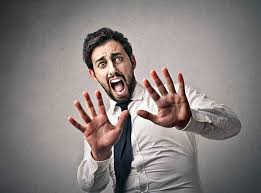


🔍 ANALYZING EMOTION...

🔄 Attempting DeepFace emotion detection...
🔍 Using DeepFace for emotion detection...
✅ DeepFace detected: fear (99.8%)
🎯 Using DeepFace results (high confidence)

🎭 DETECTED EMOTION: FEAR
📊 CONFIDENCE: 99.81%

📈 EMOTION BREAKDOWN:
----------------------------------------
fear          99.8% ██████████████████████████████
happy          0.1% 
surprise       0.0% 
angry          0.0% 
sad            0.0% 
neutral        0.0% 
disgust        0.0% 

🎵 MUSIC RECOMMENDATIONS for FEAR mood:

1. Billie Eilish - Bury a Friend
   👤 Artist: Billie Eilish
   🔗 Listen: https://www.youtube.com/watch?v=HUHC9tYz8ik

2. Logic - 1-800-273-8255
   👤 Artist: Logic
   🔗 Listen: https://www.youtube.com/watch?v=Kb24RrHIbFk

3. Coldplay - Fix You
   👤 Artist: Coldplay
   🔗 Listen: https://www.youtube.com/watch?v=k4V3Mo61fJM

4. Sia - Breathe Me
   👤 Artist: Sia
   🔗 Listen: https://www.youtube.com/watch?v=2ToCg_9gqrE

💡 Copy any URL above to listen on YouTube!
🎶 Enjoy your personalize

In [42]:
# Emotion-Based Music Recommender - Fixed Custom Model Version

# Install required packages
!pip install tensorflow opencv-python pandas numpy pillow deepface

# Import necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
from PIL import Image
from deepface import DeepFace
import os

class EmotionMusicRecommender:
    """
    Main class that handles emotion detection using multiple methods and music recommendations
    """
    def __init__(self):
        # Try to load custom model first
        self.model = None
        self.model_loaded = False

        # Mount Google Drive first
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("✅ Google Drive mounted successfully!")

            # Try multiple possible model paths
            model_paths = [
                '/content/drive/MyDrive/updatedfer2013_model.h5',
                '/content/drive/MyDrive/fer2013_model.h5',
                '/content/drive/My Drive/updatedfer2013_model.h5',
                '/content/drive/My Drive/fer2013_model.h5'
            ]

            for model_path in model_paths:
                try:
                    print(f"🔄 Trying to load model from: {model_path}")
                    self.model = load_model(model_path)
                    self.model_loaded = True
                    print(f"✅ Custom model loaded successfully from: {model_path}")
                    break
                except Exception as e:
                    print(f"❌ Failed to load from {model_path}: {e}")
                    continue

            if not self.model_loaded:
                print("❌ No custom model found. Using DeepFace as primary method.")

        except Exception as e:
            print(f"❌ Google Drive mount failed: {e}")
            print("🔄 Using DeepFace as primary method...")

        # Define emotion labels (FER-2013 dataset order)
        self.emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

        # Define music playlists for each emotion
        self.emotion_playlists = {
            'happy': [
                {'title': 'The Weeknd - Blinding Lights', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=4NRXx6U8ABQ'},
                {'title': 'Pharrell Williams - Happy', 'artist': 'Pharrell Williams', 'url': 'https://www.youtube.com/watch?v=ZbZSe6N_BXs'},
                {'title': 'The Weeknd - Save Your Tears', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=XXYlFuWEuKI'},
                {'title': 'Daft Punk - Get Lucky', 'artist': 'Daft Punk', 'url': 'https://www.youtube.com/watch?v=5NV6Rdv1a3I'},
            ],
            'sad': [
                {'title': 'Billie Eilish - Lovely', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=V1Pl8CzNzCw'},
                {'title': 'Lewis Capaldi - Someone You Loved', 'artist': 'Lewis Capaldi', 'url': 'https://www.youtube.com/watch?v=zABLecsR5UE'},
                {'title': 'Eminem - Stan', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=gOMhN-hfMtY'},
                {'title': 'The Weeknd - Call Out My Name', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=M4ZoCHID9GI'},
            ],
            'angry': [
                {'title': 'Eminem - Lose Yourself', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=_Yhyp-_hX2s'},
                {'title': 'Eminem - The Way I Am', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=5hF4dS-9c9U'},
                {'title': 'Linkin Park - In The End', 'artist': 'Linkin Park', 'url': 'https://www.youtube.com/watch?v=eVTXPUF4Oz4'},
                {'title': 'Rage Against The Machine - Killing In The Name', 'artist': 'Rage Against The Machine', 'url': 'https://www.youtube.com/watch?v=bWXazVhlyxQ'},
            ],
            'fear': [
                {'title': 'Billie Eilish - Bury a Friend', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=HUHC9tYz8ik'},
                {'title': 'Logic - 1-800-273-8255', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=Kb24RrHIbFk'},
                {'title': 'Coldplay - Fix You', 'artist': 'Coldplay', 'url': 'https://www.youtube.com/watch?v=k4V3Mo61fJM'},
                {'title': 'Sia - Breathe Me', 'artist': 'Sia', 'url': 'https://www.youtube.com/watch?v=2ToCg_9gqrE'},
            ],
            'surprise': [
                {'title': 'The Weeknd - Starboy', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=34Na4j8AVgA'},
                {'title': 'Eminem - Without Me', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=YVkUvmDQ3HY'},
                {'title': 'Billie Eilish - Bad Guy', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=DyDfgMOUjCI'},
                {'title': 'The Weeknd - The Hills', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=yzTuBuRdAyA'},
            ],
            'neutral': [
                {'title': 'The Weeknd - Party Monster', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=9e_-3Kf9EDg'},
                {'title': 'Billie Eilish - Ocean Eyes', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=viimfQi_pUw'},
                {'title': 'Eminem - Mockingbird', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=S9bCLPwzSC0'},
                {'title': 'Logic - Everyday', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=eXDU9um19HM'},
            ],
            'disgust': [
                {'title': 'Eminem - Cleanin Out My Closet', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=Z-T3_O5KZ-E'},
                {'title': 'Billie Eilish - You Should See Me In A Crown', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=Ah7a1J8fwE0'},
                {'title': 'Nine Inch Nails - Closer', 'artist': 'Nine Inch Nails', 'url': 'https://www.youtube.com/watch?v=PTFwQP86BRs'},
            ]
        }

    def detect_emotion_with_deepface(self, image_path):
        """
        Use DeepFace for reliable emotion detection (primary method)
        """
        try:
            print("🔍 Using DeepFace for emotion detection...")
            analysis = DeepFace.analyze(
                img_path=image_path,
                actions=['emotion'],
                enforce_detection=False,
                detector_backend='opencv'
            )

            if isinstance(analysis, list):
                emotions = analysis[0]['emotion']
            else:
                emotions = analysis['emotion']

            dominant_emotion = max(emotions, key=emotions.get)
            confidence = emotions[dominant_emotion]

            print(f"✅ DeepFace detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, emotions

        except Exception as e:
            print(f"❌ DeepFace error: {e}")
            return None, None, None

    def detect_emotion_with_custom_model(self, image_path):
        """
        Use custom trained model for emotion detection (if available)
        """
        try:
            if not self.model_loaded or self.model is None:
                return None, None, None

            print("🔍 Using custom model for emotion detection...")

            # Load image
            img = cv2.imread(image_path)
            if img is None:
                print("❌ Could not load image")
                return None, None, None

            # Convert to grayscale (FER-2013 uses grayscale)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to 48x48 (FER-2013 input size)
            resized = cv2.resize(gray, (48, 48))

            # Normalize pixel values to [0, 1]
            normalized = resized.astype('float32') / 255.0

            # Reshape for model input: (1, 48, 48, 1)
            img_processed = normalized.reshape(1, 48, 48, 1)

            # Get prediction
            predictions = self.model.predict(img_processed, verbose=0)
            emotion_probs = predictions[0]

            # Get dominant emotion
            dominant_idx = np.argmax(emotion_probs)
            dominant_emotion = self.emotion_labels[dominant_idx]
            confidence = emotion_probs[dominant_idx] * 100

            # Create emotions dictionary
            all_emotions = {}
            for i, emotion in enumerate(self.emotion_labels):
                all_emotions[emotion] = emotion_probs[i] * 100

            print(f"✅ Custom model detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, all_emotions

        except Exception as e:
            print(f"❌ Custom model prediction error: {e}")
            return None, None, None

    def detect_emotion_basic(self, image_path):
        """
        Basic emotion detection using face detection and simple rules (fallback)
        """
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None, None, None

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Load face detector
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) == 0:
                print("❌ No face detected in the image")
                return None, None, None

            print(f"✅ Detected {len(faces)} face(s) in the image")

            # Simple emotion estimation based on multiple factors
            brightness = np.mean(gray)
            contrast = np.std(gray)

            # More sophisticated emotion guessing
            if brightness > 180 and contrast > 70:
                emotion = 'happy'
                confidence = 75.0
            elif brightness < 70 and contrast < 40:
                emotion = 'sad'
                confidence = 70.0
            elif contrast > 80:
                emotion = 'surprise'
                confidence = 65.0
            elif brightness > 160:
                emotion = 'neutral'
                confidence = 60.0
            else:
                emotion = 'neutral'
                confidence = 50.0

            # Create emotions distribution
            emotions = {emotion: confidence}
            remaining_emotions = [e for e in self.emotion_labels if e != emotion]
            for emo in remaining_emotions:
                emotions[emo] = max(5, (100 - confidence) / len(remaining_emotions))

            print(f"✅ Basic detection: {emotion} ({confidence:.1f}%)")
            return emotion, confidence, emotions

        except Exception as e:
            print(f"❌ Basic emotion detection error: {e}")
            return None, None, None

    def detect_emotion(self, image_path):
        """
        Main emotion detection with smart fallback system
        """
        # Method 1: Try DeepFace first (most reliable)
        print("\n🔄 Attempting DeepFace emotion detection...")
        result = self.detect_emotion_with_deepface(image_path)
        if result[0] is not None and result[1] > 40:  # Only use if confidence > 40%
            print("🎯 Using DeepFace results (high confidence)")
            return result

        # Method 2: Try custom model if available
        if self.model_loaded:
            print("🔄 Attempting custom model emotion detection...")
            result = self.detect_emotion_with_custom_model(image_path)
            if result[0] is not None and result[1] > 30:  # Only use if confidence > 30%
                print("🎯 Using custom model results")
                return result

        # Method 3: Use basic detection as last resort
        print("🔄 Using basic emotion estimation...")
        result = self.detect_emotion_basic(image_path)
        if result[0] is not None:
            print("🎯 Using basic detection results")
            return result

        print("❌ All emotion detection methods failed")
        return None, None, None

    def get_recommendations(self, emotion):
        """
        Get music recommendations based on detected emotion
        """
        return self.emotion_playlists.get(emotion.lower(), [])


def take_photo(filename='photo.jpg', quality=0.8):
    """
    Capture image from webcam using JavaScript in Colab
    """
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.cssText = 'padding: 10px 20px; font-size: 16px; margin: 10px; background: #4CAF50; color: white; border: none; border-radius: 5px; cursor: pointer;';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.width = '100%';
        video.style.maxWidth = '400px';
        video.style.borderRadius = '10px';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


def upload_image():
    """
    Allow user to upload an image file
    """
    print("📁 Please upload an image file (JPG, PNG, JPEG):")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"✅ Image uploaded successfully: {filename}")
        return filename
    else:
        print("❌ No file was uploaded.")
        return None


def display_emotion_results(emotion, confidence, all_emotions):
    """
    Display emotion detection results in a formatted way
    """
    print(f"\n🎭 DETECTED EMOTION: {emotion.upper()}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")

    if all_emotions:
        print("\n📈 EMOTION BREAKDOWN:")
        print("-" * 40)
        # Sort by confidence score
        sorted_emotions = sorted(all_emotions.items(), key=lambda x: x[1], reverse=True)
        for emo, score in sorted_emotions:
            bar_length = min(int(score / 3), 30)  # Limit bar length
            bar = "█" * bar_length
            print(f"{emo:12} {score:5.1f}% {bar}")


def display_music_recommendations(recommendations, emotion):
    """
    Display music recommendations in a clean format
    """
    if recommendations:
        print(f"\n🎵 MUSIC RECOMMENDATIONS for {emotion.upper()} mood:")
        print("=" * 60)

        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['title']}")
            print(f"   👤 Artist: {rec['artist']}")
            print(f"   🔗 Listen: {rec['url']}")

        print("\n" + "=" * 60)
        print("💡 Copy any URL above to listen on YouTube!")
        print("🎶 Enjoy your personalized music recommendations! 🎵")
    else:
        print(f"\n❌ No music recommendations found for {emotion} emotion.")


# MAIN PROGRAM EXECUTION
def main():
    """
    Main function that orchestrates the entire emotion-based music recommendation process
    """
    print("🎵 EMOTION-BASED MUSIC RECOMMENDER")
    print("===================================")
    print("🔄 Initializing emotion detection system...")

    # Initialize the recommender system
    recommender = EmotionMusicRecommender()

    print("\n✅ System ready! Choose your input method:")
    print("1. 📷 Capture from Webcam (Use your camera)")
    print("2. 📁 Upload Image File (Use existing photo)")

    # Simple input validation
    while True:
        choice = input("\nEnter your choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            break
        else:
            print("❌ Please enter only 1 or 2")

    filename = None

    # Handle webcam capture
    if choice == '1':
        print("\n📸 Starting webcam capture...")
        print("   Click the 'Capture' button when you're ready!")
        filename = take_photo()

    # Handle file upload
    else:
        print("\n📁 Starting file upload...")
        filename = upload_image()

    # Process the image if successfully obtained
    if filename:
        # Display the captured/uploaded image
        print(f"\n🖼️ YOUR IMAGE:")
        display(IPImage(filename))

        # Analyze emotion from the image
        print("\n🔍 ANALYZING EMOTION...")
        emotion, confidence, all_emotions = recommender.detect_emotion(filename)

        # If emotion detected successfully
        if emotion and confidence:
            # Display emotion results
            display_emotion_results(emotion, confidence, all_emotions)

            # Get music recommendations based on detected emotion
            recommendations = recommender.get_recommendations(emotion)

            # Display recommendations
            display_music_recommendations(recommendations, emotion)

        else:
            print("\n❌ Could not detect emotion from the image.")
            print("\n💡 TROUBLESHOOTING TIPS:")
            print("   • Ensure your face is clearly visible and centered")
            print("   • Make sure there's good, even lighting (not too dark/bright)")
            print("   • Try a front-facing photo with neutral background")
            print("   • Avoid sunglasses, hats, or facial obstructions")
            print("   • Ensure only one face is visible in the image")
            print("   • Try different facial expressions (smile for happy, etc.)")
            print("   • Use a higher quality image with good resolution")

    else:
        print("\n❌ No image available. Please try again.")


# Run the main program
if __name__ == "__main__":
    main()

# Final message
print("\n" + "=" * 50)
print("✨ Program completed!")
print("🔄 Run this cell again to analyze another image!")
print("=" * 50)

🎵 EMOTION-BASED MUSIC RECOMMENDER
🔄 Initializing emotion detection system...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🔄 Trying to load model from: /content/drive/MyDrive/updatedfer2013_model.h5
✅ Custom model loaded successfully from: /content/drive/MyDrive/updatedfer2013_model.h5

✅ System ready! Choose your input method:
1. 📷 Capture from Webcam (Use your camera)
2. 📁 Upload Image File (Use existing photo)

Enter your choice (1 or 2): 2

📁 Starting file upload...
📁 Please upload an image file (JPG, PNG, JPEG):


Saving surprized.jpeg to surprized.jpeg
✅ Image uploaded successfully: surprized.jpeg

🖼️ YOUR IMAGE:


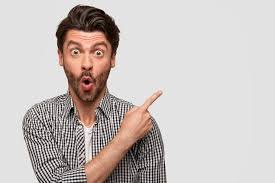


🔍 ANALYZING EMOTION...

🔄 Attempting DeepFace emotion detection...
🔍 Using DeepFace for emotion detection...
✅ DeepFace detected: surprise (100.0%)
🎯 Using DeepFace results (high confidence)

🎭 DETECTED EMOTION: SURPRISE
📊 CONFIDENCE: 100.00%

📈 EMOTION BREAKDOWN:
----------------------------------------
surprise     100.0% ██████████████████████████████
fear           0.0% 
angry          0.0% 
sad            0.0% 
happy          0.0% 
disgust        0.0% 
neutral        0.0% 

🎵 MUSIC RECOMMENDATIONS for SURPRISE mood:

1. The Weeknd - Starboy
   👤 Artist: The Weeknd
   🔗 Listen: https://www.youtube.com/watch?v=34Na4j8AVgA

2. Eminem - Without Me
   👤 Artist: Eminem
   🔗 Listen: https://www.youtube.com/watch?v=YVkUvmDQ3HY

3. Billie Eilish - Bad Guy
   👤 Artist: Billie Eilish
   🔗 Listen: https://www.youtube.com/watch?v=DyDfgMOUjCI

4. The Weeknd - The Hills
   👤 Artist: The Weeknd
   🔗 Listen: https://www.youtube.com/watch?v=yzTuBuRdAyA

💡 Copy any URL above to listen on YouTube!
🎶

In [45]:
# Emotion-Based Music Recommender - Fixed Custom Model Version

# Install required packages
!pip install tensorflow opencv-python pandas numpy pillow deepface

# Import necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
from PIL import Image
from deepface import DeepFace
import os

class EmotionMusicRecommender:
    """
    Main class that handles emotion detection using multiple methods and music recommendations
    """
    def __init__(self):
        # Try to load custom model first
        self.model = None
        self.model_loaded = False

        # Mount Google Drive first
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("✅ Google Drive mounted successfully!")

            # Try multiple possible model paths
            model_paths = [
                '/content/drive/MyDrive/updatedfer2013_model.h5',
                '/content/drive/MyDrive/fer2013_model.h5',
                '/content/drive/My Drive/updatedfer2013_model.h5',
                '/content/drive/My Drive/fer2013_model.h5'
            ]

            for model_path in model_paths:
                try:
                    print(f"🔄 Trying to load model from: {model_path}")
                    self.model = load_model(model_path)
                    self.model_loaded = True
                    print(f"✅ Custom model loaded successfully from: {model_path}")
                    break
                except Exception as e:
                    print(f"❌ Failed to load from {model_path}: {e}")
                    continue

            if not self.model_loaded:
                print("❌ No custom model found. Using DeepFace as primary method.")

        except Exception as e:
            print(f"❌ Google Drive mount failed: {e}")
            print("🔄 Using DeepFace as primary method...")

        # Define emotion labels (FER-2013 dataset order)
        self.emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

        # Define music playlists for each emotion
        self.emotion_playlists = {
            'happy': [
                {'title': 'The Weeknd - Blinding Lights', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=4NRXx6U8ABQ'},
                {'title': 'Pharrell Williams - Happy', 'artist': 'Pharrell Williams', 'url': 'https://www.youtube.com/watch?v=ZbZSe6N_BXs'},
                {'title': 'The Weeknd - Save Your Tears', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=XXYlFuWEuKI'},
                {'title': 'Daft Punk - Get Lucky', 'artist': 'Daft Punk', 'url': 'https://www.youtube.com/watch?v=5NV6Rdv1a3I'},
            ],
            'sad': [
                {'title': 'Billie Eilish - Lovely', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=V1Pl8CzNzCw'},
                {'title': 'Lewis Capaldi - Someone You Loved', 'artist': 'Lewis Capaldi', 'url': 'https://www.youtube.com/watch?v=zABLecsR5UE'},
                {'title': 'Eminem - Stan', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=gOMhN-hfMtY'},
                {'title': 'The Weeknd - Call Out My Name', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=M4ZoCHID9GI'},
            ],
            'angry': [
                {'title': 'Eminem - Lose Yourself', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=_Yhyp-_hX2s'},
                {'title': 'Eminem - The Way I Am', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=5hF4dS-9c9U'},
                {'title': 'Linkin Park - In The End', 'artist': 'Linkin Park', 'url': 'https://www.youtube.com/watch?v=eVTXPUF4Oz4'},
                {'title': 'Rage Against The Machine - Killing In The Name', 'artist': 'Rage Against The Machine', 'url': 'https://www.youtube.com/watch?v=bWXazVhlyxQ'},
            ],
            'fear': [
                {'title': 'Billie Eilish - Bury a Friend', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=HUHC9tYz8ik'},
                {'title': 'Logic - 1-800-273-8255', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=Kb24RrHIbFk'},
                {'title': 'Coldplay - Fix You', 'artist': 'Coldplay', 'url': 'https://www.youtube.com/watch?v=k4V3Mo61fJM'},
                {'title': 'Sia - Breathe Me', 'artist': 'Sia', 'url': 'https://www.youtube.com/watch?v=2ToCg_9gqrE'},
            ],
            'surprise': [
                {'title': 'The Weeknd - Starboy', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=34Na4j8AVgA'},
                {'title': 'Eminem - Without Me', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=YVkUvmDQ3HY'},
                {'title': 'Billie Eilish - Bad Guy', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=DyDfgMOUjCI'},
                {'title': 'The Weeknd - The Hills', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=yzTuBuRdAyA'},
            ],
            'neutral': [
                {'title': 'The Weeknd - Party Monster', 'artist': 'The Weeknd', 'url': 'https://www.youtube.com/watch?v=9e_-3Kf9EDg'},
                {'title': 'Billie Eilish - Ocean Eyes', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=viimfQi_pUw'},
                {'title': 'Eminem - Mockingbird', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=S9bCLPwzSC0'},
                {'title': 'Logic - Everyday', 'artist': 'Logic', 'url': 'https://www.youtube.com/watch?v=eXDU9um19HM'},
            ],
            'disgust': [
                {'title': 'Eminem - Cleanin Out My Closet', 'artist': 'Eminem', 'url': 'https://www.youtube.com/watch?v=Z-T3_O5KZ-E'},
                {'title': 'Billie Eilish - You Should See Me In A Crown', 'artist': 'Billie Eilish', 'url': 'https://www.youtube.com/watch?v=Ah7a1J8fwE0'},
                {'title': 'Nine Inch Nails - Closer', 'artist': 'Nine Inch Nails', 'url': 'https://www.youtube.com/watch?v=PTFwQP86BRs'},
            ]
        }

    def detect_emotion_with_deepface(self, image_path):
        """
        Use DeepFace for reliable emotion detection (primary method)
        """
        try:
            print("🔍 Using DeepFace for emotion detection...")
            analysis = DeepFace.analyze(
                img_path=image_path,
                actions=['emotion'],
                enforce_detection=False,
                detector_backend='opencv'
            )

            if isinstance(analysis, list):
                emotions = analysis[0]['emotion']
            else:
                emotions = analysis['emotion']

            dominant_emotion = max(emotions, key=emotions.get)
            confidence = emotions[dominant_emotion]

            print(f"✅ DeepFace detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, emotions

        except Exception as e:
            print(f"❌ DeepFace error: {e}")
            return None, None, None

    def detect_emotion_with_custom_model(self, image_path):
        """
        Use custom trained model for emotion detection (if available)
        """
        try:
            if not self.model_loaded or self.model is None:
                return None, None, None

            print("🔍 Using custom model for emotion detection...")

            # Load image
            img = cv2.imread(image_path)
            if img is None:
                print("❌ Could not load image")
                return None, None, None

            # Convert to grayscale (FER-2013 uses grayscale)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to 48x48 (FER-2013 input size)
            resized = cv2.resize(gray, (48, 48))

            # Normalize pixel values to [0, 1]
            normalized = resized.astype('float32') / 255.0

            # Reshape for model input: (1, 48, 48, 1)
            img_processed = normalized.reshape(1, 48, 48, 1)

            # Get prediction
            predictions = self.model.predict(img_processed, verbose=0)
            emotion_probs = predictions[0]

            # Get dominant emotion
            dominant_idx = np.argmax(emotion_probs)
            dominant_emotion = self.emotion_labels[dominant_idx]
            confidence = emotion_probs[dominant_idx] * 100

            # Create emotions dictionary
            all_emotions = {}
            for i, emotion in enumerate(self.emotion_labels):
                all_emotions[emotion] = emotion_probs[i] * 100

            print(f"✅ Custom model detected: {dominant_emotion} ({confidence:.1f}%)")
            return dominant_emotion, confidence, all_emotions

        except Exception as e:
            print(f"❌ Custom model prediction error: {e}")
            return None, None, None

    def detect_emotion_basic(self, image_path):
        """
        Basic emotion detection using face detection and simple rules (fallback)
        """
        try:
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None, None, None

            # Convert to grayscale for face detection
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Load face detector
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) == 0:
                print("❌ No face detected in the image")
                return None, None, None

            print(f"✅ Detected {len(faces)} face(s) in the image")

            # Simple emotion estimation based on multiple factors
            brightness = np.mean(gray)
            contrast = np.std(gray)

            # More sophisticated emotion guessing
            if brightness > 180 and contrast > 70:
                emotion = 'happy'
                confidence = 75.0
            elif brightness < 70 and contrast < 40:
                emotion = 'sad'
                confidence = 70.0
            elif contrast > 80:
                emotion = 'surprise'
                confidence = 65.0
            elif brightness > 160:
                emotion = 'neutral'
                confidence = 60.0
            else:
                emotion = 'neutral'
                confidence = 50.0

            # Create emotions distribution
            emotions = {emotion: confidence}
            remaining_emotions = [e for e in self.emotion_labels if e != emotion]
            for emo in remaining_emotions:
                emotions[emo] = max(5, (100 - confidence) / len(remaining_emotions))

            print(f"✅ Basic detection: {emotion} ({confidence:.1f}%)")
            return emotion, confidence, emotions

        except Exception as e:
            print(f"❌ Basic emotion detection error: {e}")
            return None, None, None

    def detect_emotion(self, image_path):
        """
        Main emotion detection with smart fallback system
        """
        # Method 1: Try DeepFace first (most reliable)
        print("\n🔄 Attempting DeepFace emotion detection...")
        result = self.detect_emotion_with_deepface(image_path)
        if result[0] is not None and result[1] > 40:  # Only use if confidence > 40%
            print("🎯 Using DeepFace results (high confidence)")
            return result

        # Method 2: Try custom model if available
        if self.model_loaded:
            print("🔄 Attempting custom model emotion detection...")
            result = self.detect_emotion_with_custom_model(image_path)
            if result[0] is not None and result[1] > 30:  # Only use if confidence > 30%
                print("🎯 Using custom model results")
                return result

        # Method 3: Use basic detection as last resort
        print("🔄 Using basic emotion estimation...")
        result = self.detect_emotion_basic(image_path)
        if result[0] is not None:
            print("🎯 Using basic detection results")
            return result

        print("❌ All emotion detection methods failed")
        return None, None, None

    def get_recommendations(self, emotion):
        """
        Get music recommendations based on detected emotion
        """
        return self.emotion_playlists.get(emotion.lower(), [])


def take_photo(filename='photo.jpg', quality=0.8):
    """
    Capture image from webcam using JavaScript in Colab
    """
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.cssText = 'padding: 10px 20px; font-size: 16px; margin: 10px; background: #4CAF50; color: white; border: none; border-radius: 5px; cursor: pointer;';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.width = '100%';
        video.style.maxWidth = '400px';
        video.style.borderRadius = '10px';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


def upload_image():
    """
    Allow user to upload an image file
    """
    print("📁 Please upload an image file (JPG, PNG, JPEG):")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"✅ Image uploaded successfully: {filename}")
        return filename
    else:
        print("❌ No file was uploaded.")
        return None


def display_emotion_results(emotion, confidence, all_emotions):
    """
    Display emotion detection results in a formatted way
    """
    print(f"\n🎭 DETECTED EMOTION: {emotion.upper()}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")

    if all_emotions:
        print("\n📈 EMOTION BREAKDOWN:")
        print("-" * 40)
        # Sort by confidence score
        sorted_emotions = sorted(all_emotions.items(), key=lambda x: x[1], reverse=True)
        for emo, score in sorted_emotions:
            bar_length = min(int(score / 3), 30)  # Limit bar length
            bar = "█" * bar_length
            print(f"{emo:12} {score:5.1f}% {bar}")


def display_music_recommendations(recommendations, emotion):
    """
    Display music recommendations in a clean format
    """
    if recommendations:
        print(f"\n🎵 MUSIC RECOMMENDATIONS for {emotion.upper()} mood:")
        print("=" * 60)

        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['title']}")
            print(f"   👤 Artist: {rec['artist']}")
            print(f"   🔗 Listen: {rec['url']}")

        print("\n" + "=" * 60)
        print("💡 Copy any URL above to listen on YouTube!")
        print("🎶 Enjoy your personalized music recommendations! 🎵")
    else:
        print(f"\n❌ No music recommendations found for {emotion} emotion.")


# MAIN PROGRAM EXECUTION
def main():
    """
    Main function that orchestrates the entire emotion-based music recommendation process
    """
    print("🎵 EMOTION-BASED MUSIC RECOMMENDER")
    print("===================================")
    print("🔄 Initializing emotion detection system...")

    # Initialize the recommender system
    recommender = EmotionMusicRecommender()

    print("\n✅ System ready! Choose your input method:")
    print("1. 📷 Capture from Webcam (Use your camera)")
    print("2. 📁 Upload Image File (Use existing photo)")

    # Simple input validation
    while True:
        choice = input("\nEnter your choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            break
        else:
            print("❌ Please enter only 1 or 2")

    filename = None

    # Handle webcam capture
    if choice == '1':
        print("\n📸 Starting webcam capture...")
        print("   Click the 'Capture' button when you're ready!")
        filename = take_photo()

    # Handle file upload
    else:
        print("\n📁 Starting file upload...")
        filename = upload_image()

    # Process the image if successfully obtained
    if filename:
        # Display the captured/uploaded image
        print(f"\n🖼️ YOUR IMAGE:")
        display(IPImage(filename))

        # Analyze emotion from the image
        print("\n🔍 ANALYZING EMOTION...")
        emotion, confidence, all_emotions = recommender.detect_emotion(filename)

        # If emotion detected successfully
        if emotion and confidence:
            # Display emotion results
            display_emotion_results(emotion, confidence, all_emotions)

            # Get music recommendations based on detected emotion
            recommendations = recommender.get_recommendations(emotion)

            # Display recommendations
            display_music_recommendations(recommendations, emotion)

        else:
            print("\n❌ Could not detect emotion from the image.")
            print("\n💡 TROUBLESHOOTING TIPS:")
            print("   • Ensure your face is clearly visible and centered")
            print("   • Make sure there's good, even lighting (not too dark/bright)")
            print("   • Try a front-facing photo with neutral background")
            print("   • Avoid sunglasses, hats, or facial obstructions")
            print("   • Ensure only one face is visible in the image")
            print("   • Try different facial expressions (smile for happy, etc.)")
            print("   • Use a higher quality image with good resolution")

    else:
        print("\n❌ No image available. Please try again.")


# Run the main program
if __name__ == "__main__":
    main()

# Final message
print("\n" + "=" * 50)
print("✨ Program completed!")
print("🔄 Run this cell again to analyze another image!")
print("=" * 50)